# MMAE 500 - Homework 2
# Jay Steinberg

In [13]:
import numpy as np
from numpy import linalg 
from matplotlib import cm
from matplotlib import pyplot as plt

y = np.linspace(-2,2,401) # spatial coordinate
Ny = np.size(y)

amp1 = 1
y01 = 0.5
sigmay1 = 0.6

amp2 = 1.2
y02 = -0.5
sigmay2 = 0.3

dt = 0.1
Nt = 101
tend = dt*(Nt-1)
t = np.linspace(0,tend,Nt) # time

omega1 = 1.3
omega2 = 4.1

v1 = amp1*np.exp(-((y-y01)**2)/(2*sigmay1**2))
v2 = amp2*np.exp(-((y-y02)**2)/(2*sigmay2**2))

X = np.zeros([Ny,Nt],dtype=complex)
for tt in range(Nt):
    X[:,tt] = v1*np.cos(omega1*t[tt])+v2*np.cos(omega2*t[tt]) 

# Q2. 
Consider the data generated by the file hw2Q2.ipynb 
(Python notebook), which is assembled into the matrix X. Note that this is the
same data as was considered in Homework 1.

  (a) Compute the SVD of X, and plot the first two left singular vectors against
y (the spatial coordinate). Why are the first two singular values much
larger than the rest (which are essentially zero)?

Left singular vectors U:
 [[-1.36201017e-05+0.j  1.03178928e-05+0.j -8.61153984e-01+0.j ...
  -2.02512964e-05+0.j -1.08182843e-04+0.j  1.33747383e-04+0.j]
 [-1.46191027e-05+0.j  1.10042257e-05+0.j  4.94318946e-01+0.j ...
  -3.00933900e-05+0.j -3.99251893e-04+0.j -3.87490431e-04+0.j]
 [-1.56891053e-05+0.j  1.17273519e-05+0.j  5.32341365e-07+0.j ...
  -3.34931990e-03+0.j -2.57852516e-03+0.j -2.40875204e-03+0.j]
 ...
 [-3.77152329e-03+0.j  3.03885108e-03+0.j -5.56271965e-04+0.j ...
   9.97539101e-01+0.j  6.21908430e-05+0.j -2.21802749e-04+0.j]
 [-3.61911302e-03+0.j  2.91604868e-03+0.j  2.36839726e-04+0.j ...
   9.14016858e-05+0.j  9.97248613e-01+0.j -1.79406146e-04+0.j]
 [-3.47189723e-03+0.j  2.79743166e-03+0.j  1.88310158e-04+0.j ...
  -2.91400285e-04+0.j -2.11968729e-04+0.j  9.97391326e-01+0.j]] 


Singular values:
 [7.96868223e+01 5.60152252e+01 2.33435323e-14 1.78743755e-14
 7.73450826e-15 7.73450826e-15 7.73450826e-15 7.73450826e-15
 7.73450826e-15 7.73450826e-15 7.73450826e-15 7.734

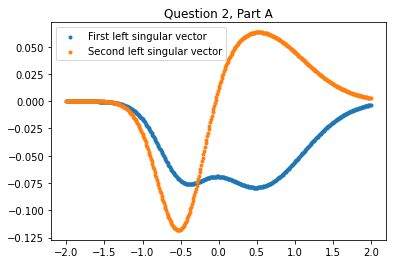

In [14]:
# print(X)

U, S, VH = linalg.svd(X)

print('Left singular vectors U:\n', U, '\n\n')
print('Singular values:\n', S, '\n\n')
print('Right singular vectors Vt:\n', VH, '\n\n')

plt.figure()
plt.title("Question 2, Part A")
plt.scatter(y, U[:,0], label="First left singular vector", marker=".")
plt.scatter(y, U[:,1], label="Second left singular vector", marker=".")
plt.legend()

(b) Design and train an autoencoder to find a reduced-dimension approximation of the data. Visualize the autoencoder modes (latent variables), and
compare them to the appropriate singular vectors from the SVD. How does
the accuracy of the autoencoder compare to that from the SVD?

In [47]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, callbacks
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

timeindex = 0;
nspace, ntime = X.shape
XMean = np.mean(X,axis=1)
XSub = X - np.tile(XMean[:,np.newaxis],(1,ntime))
# XReshape = np.reshape(X[:,timeindex],(nspace,ntime))

# Build a simple autoencoder

inputs = keras.Input(shape = (nspace,))

# add a hidden layer
encodedDim = 2
hiddenLayer = layers.Dense(encodedDim,activation ='linear')
#hiddenLayer = layers.Dense(encodedDim,activation ='tanh')

encoding = hiddenLayer(inputs)
encoder = keras.Model(inputs,encoding,name="encoder")
print(encoder.summary())

# decoder

decoder_input = layers.Input(shape = (encodedDim,))
# add output layer
outputlayer = layers.Dense(nspace,activation = 'linear')
#outputlayer = layers.Dense(nspace,activation = 'tanh')#
outputs = outputlayer(decoder_input)

decoder = keras.Model(decoder_input,outputs,name="decoder")
print(decoder.summary())

# define autoencoder

output_auto = decoder(encoder(inputs)) # xapprox = g(f(x))

model = models.Model(inputs,output_auto)
print(model.summary())

# training

TrainingInputs = np.transpose(XSub)
TrainingOutputs = np.transpose(XSub)
model.compile(loss = 'mse',optimizer='adam')

history = model.fit(TrainingInputs,TrainingOutputs,batch_size=62,epochs = 200)



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 401)]             0         
                                                                 
 dense_10 (Dense)            (None, 2)                 804       
                                                                 
Total params: 804
Trainable params: 804
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 401)               1203      
                                                                 
Total params: 1,203
Trainable params: 1

4/4 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


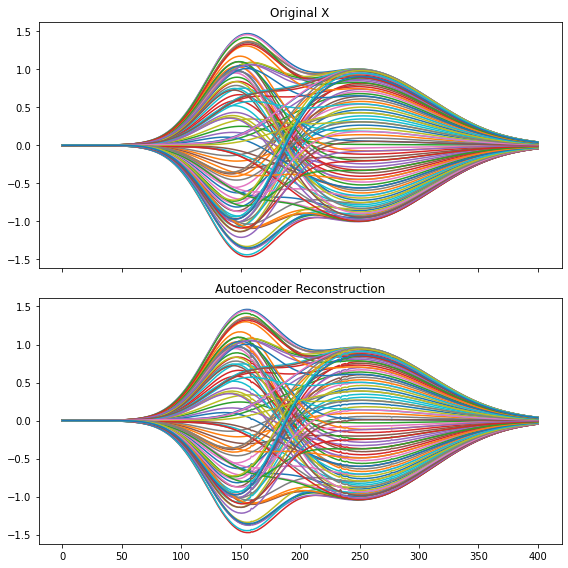

In [48]:
# full data

TestData = np.transpose(XSub)
ReconstructedData = model.predict(TestData)
ReconstructedDataT = np.transpose(ReconstructedData)

# plot data
fig, ax = plt.subplots(2, sharex=True, figsize=(8,8))
ax[0].plot(X)
ax[0].set_title('Original X')
ax[1].plot(ReconstructedDataT)
ax[1].set_title('Autoencoder Reconstruction')
fig.tight_layout()
fig.show()


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


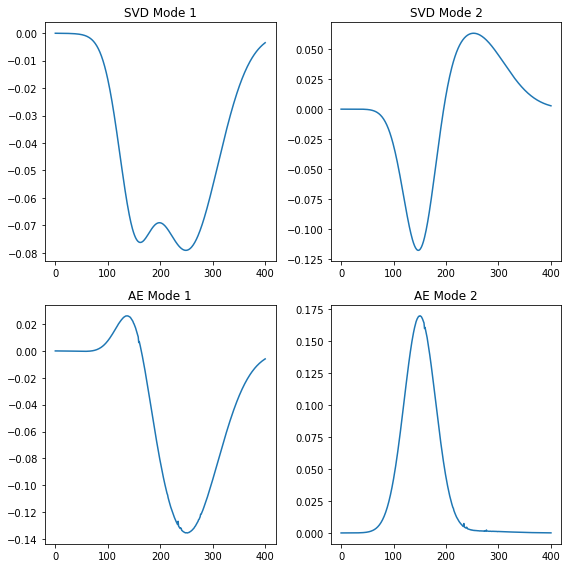

In [50]:
# Visualize autoencoder modes

toDecode = np.diag(np.ones((encodedDim,)))
AEmodes = decoder.predict(toDecode)
AEmode1 = AEmodes[0,:]
AEmode2 = AEmodes[1,:]

# Visualize SVD modes
U, S, VH = linalg.svd(XSub, full_matrices=0)

Ur = U[:,:encodedDim]
VHr = VH[:encodedDim,:]
Sr = np.diag(S[:encodedDim])

SVDmode1 = Ur[:,0]
SVDmode2 = Ur[:,1]

figSVD, axSVD = plt.subplots(2,2, figsize=(8,8))
axSVD[0,0].plot(SVDmode1)
axSVD[0,0].set_title('SVD Mode 1')
axSVD[0,1].plot(SVDmode2)
axSVD[0,1].set_title('SVD Mode 2')
axSVD[1,0].plot(AEmode1)
axSVD[1,0].set_title('AE Mode 1')
axSVD[1,1].plot(AEmode2)
axSVD[1,1].set_title('AE Mode 2')
figSVD.tight_layout()
figSVD.show()


# Q3. 
Change the function that generates the data such that the spatial peaks (i.e.
the Gaussians) change their location with time. How you do this is up to you, so
this question is a bit open ended. How does this change the results of question
2?

In [53]:
# Change to generating function

X2 = np.zeros([Ny,Nt],dtype=complex)
for tt in range(Nt):
    # X2[:,tt] = v1*np.cos(omega1*t[tt]*tt)+v2*np.cos(omega2*t[tt]*tt]) 
    # X2[:,tt] = v1*np.cos(omega1*t[tt]*0.4*tt])+v2*np.cos(omega2*t[tt]*0.4*tt) 
    # X2[:,tt] = v1*np.cos(omega1*t[tt]+tt)+v2*np.cos(omega2*t[tt]*t[tt]+tt) 
    X2[:,tt] = v1*np.cos(omega1*t[tt]*t[tt])+v2*np.cos(omega2*t[tt]*t[tt]) 



# Note: see above, I have tried several different modifications to the generating function for X in hopes of relocating the spatial peaks with time. I'm not sure any of them have accomplished the goal.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Modified X2')

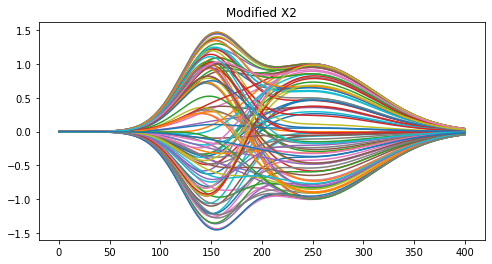

In [57]:
fig2, ax2 = plt.subplots(1, sharex=True, figsize=(8,4))
ax2.plot(X2)
ax2.set_title('Modified X2')

4/4 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1/1 [==============================] - 0s 45ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


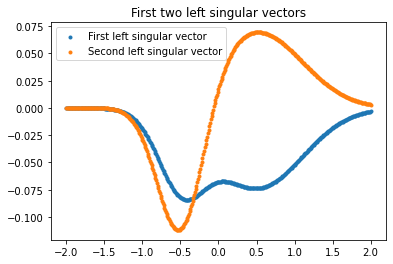

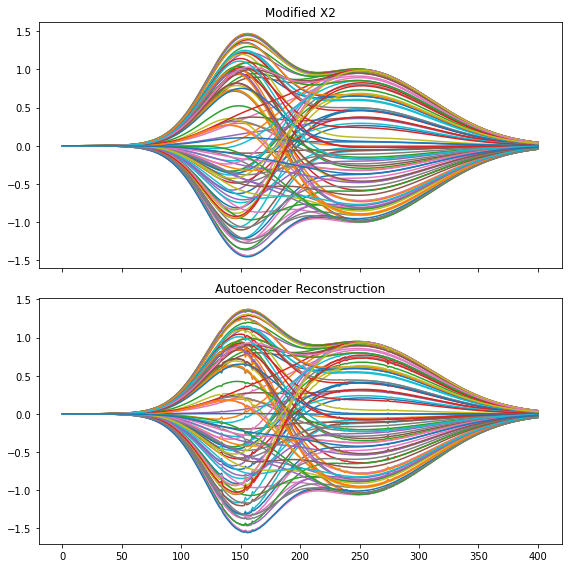

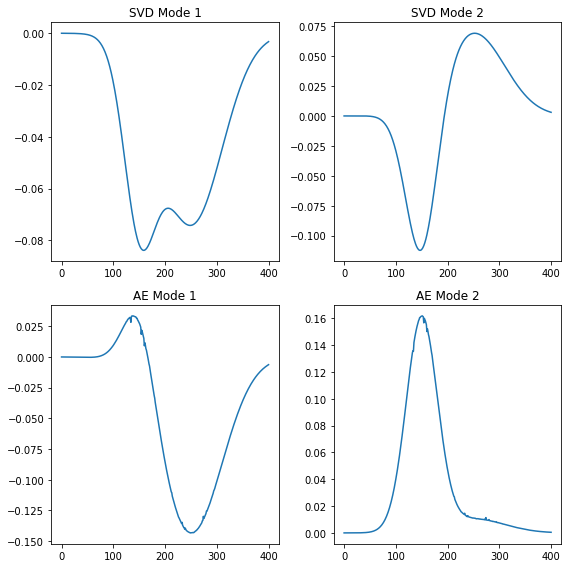

In [59]:
# Copied from many cells above for Q2 but using new X2

U2, S2, VH2 = linalg.svd(X2)

# print('Left singular vectors U:\n', U, '\n\n')
# print('Singular values:\n', S, '\n\n')
# print('Right singular vectors Vt:\n', VH, '\n\n')

plt.figure()
plt.title("First two left singular vectors")
plt.scatter(y, U2[:,0], label="First left singular vector", marker=".")
plt.scatter(y, U2[:,1], label="Second left singular vector", marker=".")
plt.legend()

timeindex = 0;
nspace, ntime = X2.shape
X2Mean = np.mean(X2,axis=1)
X2Sub = X2 - np.tile(X2Mean[:,np.newaxis],(1,ntime))

# Build a simple autoencoder
inputs = keras.Input(shape = (nspace,))

# add a hidden layer
encodedDim = 2
hiddenLayer = layers.Dense(encodedDim,activation ='linear')
#hiddenLayer = layers.Dense(encodedDim,activation ='tanh')

encoding = hiddenLayer(inputs)
encoder = keras.Model(inputs,encoding,name="encoder")
# print(encoder.summary())

# decoder

decoder_input = layers.Input(shape = (encodedDim,))
# add output layer
outputlayer = layers.Dense(nspace,activation = 'linear')
#outputlayer = layers.Dense(nspace,activation = 'tanh')#
outputs = outputlayer(decoder_input)

decoder = keras.Model(decoder_input,outputs,name="decoder")
# print(decoder.summary())

# define autoencoder

output_auto = decoder(encoder(inputs)) # xapprox = g(f(x))

model = models.Model(inputs,output_auto)
# print(model.summary())

# training

TrainingInputs = np.transpose(X2Sub)
TrainingOutputs = np.transpose(X2Sub)
model.compile(loss = 'mse',optimizer='adam')

history = model.fit(TrainingInputs,TrainingOutputs,batch_size=62,epochs = 200,verbose=0)

# full data

TestData = np.transpose(X2Sub)
ReconstructedData = model.predict(TestData)
ReconstructedDataT = np.transpose(ReconstructedData)

# plot data
fig, ax = plt.subplots(2, sharex=True, figsize=(8,8))
ax[0].plot(X2)
ax[0].set_title('Modified X2')
ax[1].plot(ReconstructedDataT)
ax[1].set_title('Autoencoder Reconstruction')
fig.tight_layout()
fig.show()

# Visualize autoencoder modes

toDecode = np.diag(np.ones((encodedDim,)))
AEmodes = decoder.predict(toDecode)
AEmode1 = AEmodes[0,:]
AEmode2 = AEmodes[1,:]

# Visualize SVD modes
U2, S2, VH2 = linalg.svd(X2Sub, full_matrices=0)

U2r = U2[:,:encodedDim]
VH2r = VH2[:encodedDim,:]
S2r = np.diag(S2[:encodedDim])

SVDmode1 = U2r[:,0]
SVDmode2 = U2r[:,1]

figSVD, axSVD = plt.subplots(2,2, figsize=(8,8))
axSVD[0,0].plot(SVDmode1)
axSVD[0,0].set_title('SVD Mode 1')
axSVD[0,1].plot(SVDmode2)
axSVD[0,1].set_title('SVD Mode 2')
axSVD[1,0].plot(AEmode1)
axSVD[1,0].set_title('AE Mode 1')
axSVD[1,1].plot(AEmode2)
axSVD[1,1].set_title('AE Mode 2')
figSVD.tight_layout()
figSVD.show()

# With the changes to the generating function, the modes look a bit different but not significantly. I don't expect that my changes to the generating function have accomplished the goal of moving the spatial peaks WRT time.